In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import glob
from multiprocessing import cpu_count

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
import pytorch_lightning as pl

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
torch.cuda.is_available() 

True

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style = 'whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6

In [4]:
pl.seed_everything(42)

Global seed set to 42


42

In [5]:
column_names = ['Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyroscope_X','Gyroscope_Y','Gyroscope_Z','Magnetometer_X','Magnetometer_Y','Magnetometer_Z','time']

In [6]:
dir_concreat = (os.listdir('/home/aliud/Documents/LSTM/new_data/concreat/external_concreat'), '/home/aliud/Documents/LSTM/new_data/concreat/external_concreat')
dir_ice = (os.listdir('/home/aliud/Documents/LSTM/new_data/ice/External_data_ice'), '/home/aliud/Documents/LSTM/new_data/ice/External_data_ice')
dir_titles = (os.listdir('/home/aliud/Documents/LSTM/new_data/tiles_for_blind_people/external_tiles_for_blind_people'), '/home/aliud/Documents/LSTM/new_data/tiles_for_blind_people/external_tiles_for_blind_people')
dir_wet = (os.listdir('/home/aliud/Documents/LSTM/new_data/wet_floor/external_wet_floor'), '/home/aliud/Documents/LSTM/new_data/wet_floor/external_wet_floor')
dir_wood = (os.listdir('/home/aliud/Documents/LSTM/new_data/wood/external_wood'), '/home/aliud/Documents/LSTM/new_data/wood/external_wood')

In [7]:
X_concreat = pd.concat([pd.read_csv(f'{dir_concreat[1]}/{dir_concreat[0][i]}', names=column_names).drop(column_names[6:11], axis=1) for i in range(len(dir_concreat[0]))], ignore_index=True)
X_ice = pd.concat([pd.read_csv(f'{dir_ice[1]}/{dir_ice[0][i]}', names=column_names).drop(column_names[6:11], axis=1) for i in range(len(dir_ice[0]))], ignore_index=True)
X_titles = pd.concat([pd.read_csv(f'{dir_titles[1]}/{dir_titles[0][i]}', names=column_names).drop(column_names[6:11], axis=1) for i in range(len(dir_titles[0]))], ignore_index=True)
X_wet = pd.concat([pd.read_csv(f'{dir_wet[1]}/{dir_wet[0][i]}', names=column_names).drop(column_names[6:11], axis=1) for i in range(len(dir_wet[0]))], ignore_index=True)
X_wood = pd.concat([pd.read_csv(f'{dir_wood[1]}/{dir_wood[0][i]}', names=column_names).drop(column_names[6:11], axis=1) for i in range(len(dir_wood[0]))], ignore_index=True)

In [8]:
X_concreat.drop_duplicates(ignore_index=True, inplace=True)

In [9]:
X_concreat.drop_duplicates(inplace=True)
X_ice.drop_duplicates(inplace=True)
X_titles.drop_duplicates(inplace=True)
X_wet.drop_duplicates(inplace=True)
X_wood.drop_duplicates(inplace=True)

In [10]:
scaler = StandardScaler()
scaler.fit(pd.concat([X_concreat, X_ice, X_titles, X_wet, X_wood], ignore_index=True))
# scaler = joblib.load('scaler_inner.bin')

StandardScaler()

In [11]:
X_concreat = pd.DataFrame(scaler.transform(X_concreat), columns=column_names[0:6])
X_ice = pd.DataFrame(scaler.transform(X_ice), columns=column_names[0:6])
X_titles = pd.DataFrame(scaler.transform(X_titles), columns=column_names[0:6])
X_wet = pd.DataFrame(scaler.transform(X_wet), columns=column_names[0:6])
X_wood = pd.DataFrame(scaler.transform(X_wood), columns=column_names[0:6])

In [12]:
pca = PCA(n_components=4)
pca.fit(pd.concat([X_concreat, X_ice, X_titles, X_wet, X_wood], ignore_index=True))
# pca = joblib.load('pca_inner.bin')

PCA(n_components=4)

In [13]:
# joblib.dump(scaler, 'scaler_external_1k.bin', True)
# joblib.dump(pca, 'pca_external_1k.bin', True)

In [14]:
X_concreat = pd.DataFrame(pca.fit_transform(X_concreat), columns=['F1', 'F2', 'F3', 'F4'])
X_ice = pd.DataFrame(pca.fit_transform(X_ice), columns=['F1', 'F2', 'F3', 'F4'])
X_titles = pd.DataFrame(pca.fit_transform(X_titles), columns=['F1', 'F2', 'F3', 'F4'])
X_wet = pd.DataFrame(pca.fit_transform(X_wet), columns=['F1', 'F2', 'F3', 'F4'])
X_wood = pd.DataFrame(pca.fit_transform(X_wood), columns=['F1', 'F2', 'F3', 'F4'])

In [15]:
X_concreat

,F1,F2,F3,F4
0,0.301738,-0.036237,0.708704,0.298928
1,0.246224,0.532449,0.277176,0.255650
2,0.258266,0.221154,0.489728,0.151093
3,0.353787,0.327973,0.238443,0.270142
4,0.466472,-0.191188,0.668776,0.028316
...,...,...,...,...
226726,0.396212,0.162615,0.301094,-0.122404
226727,0.662590,-0.181684,0.199060,0.716102
226728,-1.373766,-0.763236,-1.447836,-0.123426
226729,-2.487339,-0.543497,-0.719428,-0.130348


In [16]:
SERIE_LEN = 100
count_series = 1
sequences = []
sequences_df = pd.DataFrame(columns=['sequence', 'label'])
labels_names = {'concreat': 0, 'ice': 1, 'titles': 2, 'wet': 3, 'wood': 4}
lengthes = []

In [17]:
# X_concreat_tmp = []
for i in tqdm(range(len(X_concreat) - SERIE_LEN)):
    tmp = X_concreat.iloc[i: SERIE_LEN + i].copy()
    sequences.append((tmp.copy(), labels_names['concreat']))
    tmp.insert(len(X_concreat.columns), 'series_id', count_series)
    # X_concreat_tmp.append(tmp)
    count_series += 1
lengthes.append(len(sequences))
# X_concreat_wide = pd.concat(X_concreat_tmp, ignore_index=True)

100%|██████████| 226631/226631 [00:37<00:00, 5993.22it/s]


In [18]:
# X_ice_tmp = []
for i in tqdm(range(len(X_ice) - SERIE_LEN)):
    tmp = X_ice.iloc[i: SERIE_LEN + i].copy()
    sequences.append((tmp.copy(), labels_names['ice']))
    tmp.insert(len(X_ice.columns), 'series_id', count_series)
    # X_ice_tmp.append(tmp)
    count_series += 1
lengthes.append(len(sequences) - lengthes[-1])
# X_ice_wide = pd.concat(X_ice_tmp, ignore_index=True)

100%|██████████| 178545/178545 [00:28<00:00, 6173.97it/s]


In [19]:
# X_titles_tmp = []
for i in tqdm(range(len(X_titles) - SERIE_LEN)):
    tmp = X_titles.iloc[i: SERIE_LEN + i].copy()
    sequences.append((tmp.copy(), labels_names['titles']))
    tmp.insert(len(X_titles.columns), 'series_id', count_series)
    # X_titles_tmp.append(tmp)
    count_series += 1
lengthes.append(len(sequences) - lengthes[-1] - lengthes[-2])
# X_titles_wide = pd.concat(X_titles_tmp, ignore_index=True)

100%|██████████| 222859/222859 [00:36<00:00, 6123.58it/s]


In [20]:
# X_wet_tmp = []
for i in tqdm(range(len(X_wet) - SERIE_LEN)):
    tmp = X_wet.iloc[i: SERIE_LEN + i].copy()
    sequences.append((tmp.copy(), labels_names['wet']))
    tmp.insert(len(X_wet.columns), 'series_id', count_series)
    # X_wet_tmp.append(tmp)
    count_series += 1
lengthes.append(len(sequences) - lengthes[-1] - lengthes[-2] - lengthes[-3])
# X_wet_wide = pd.concat(X_wet_tmp, ignore_index=True)

  0%|          | 0/356641 [00:00<?, ?it/s]

100%|██████████| 356641/356641 [00:58<00:00, 6088.33it/s]


In [21]:
# X_wood_tmp = []
for i in tqdm(range(len(X_wood) - SERIE_LEN)):
    tmp = X_wood.iloc[i: SERIE_LEN + i].copy()
    sequences.append((tmp.copy(), labels_names['wood']))
    tmp.insert(len(X_wood.columns), 'series_id', count_series)
    # X_wood_tmp.append(tmp)
    count_series += 1
lengthes.append(len(sequences) - lengthes[-1] - lengthes[-2] - lengthes[-3] - lengthes[-4])
# X_wood_wide = pd.concat(X_wood_tmp, ignore_index=True)

100%|██████████| 365307/365307 [01:00<00:00, 5993.51it/s]


In [22]:
y_concreat = pd.DataFrame(np.zeros(lengthes[0]), columns=['Label'])
y_ice = pd.DataFrame(np.ones(lengthes[1]), columns=['Label'])
y_titles = pd.DataFrame(np.ones(lengthes[3]) * 2, columns=['Label'])
y_wet = pd.DataFrame(np.ones(lengthes[2]) * 3, columns=['Label'])
y_wood = pd.DataFrame(np.ones(lengthes[4]) * 4, columns=['Label'])

y_concreat['series_id'] = list(range(1, len(y_concreat) + 1))
y_ice['series_id'] = list(range(len(y_concreat) + 1, len(y_concreat) + len(y_ice) + 1))
y_titles['series_id'] = list(range(len(y_concreat) + len(y_ice) + 1, len(y_concreat) + len(y_ice) + len(y_titles) + 1))
y_wet['series_id'] = list(range(len(y_concreat) + len(y_ice)  + len(y_titles)+ 1, len(y_concreat) + len(y_ice) +  + len(y_titles) + len(y_wet) + 1))
y_wood['series_id'] = list(range(len(y_concreat) + len(y_ice) + len(y_titles) + len(y_wet) + 1, len(y_concreat) + len(y_ice) + len(y_titles) + len(y_wet) + len(y_wood) + 1))

In [23]:
y = pd.concat([y_concreat, y_ice, y_titles, y_wet, y_wood], ignore_index=True)

In [24]:
y

,Label,series_id
0,0.0,1
1,0.0,2
2,0.0,3
3,0.0,4
4,0.0,5
...,...,...
1349978,4.0,1349979
1349979,4.0,1349980
1349980,4.0,1349981
1349981,4.0,1349982


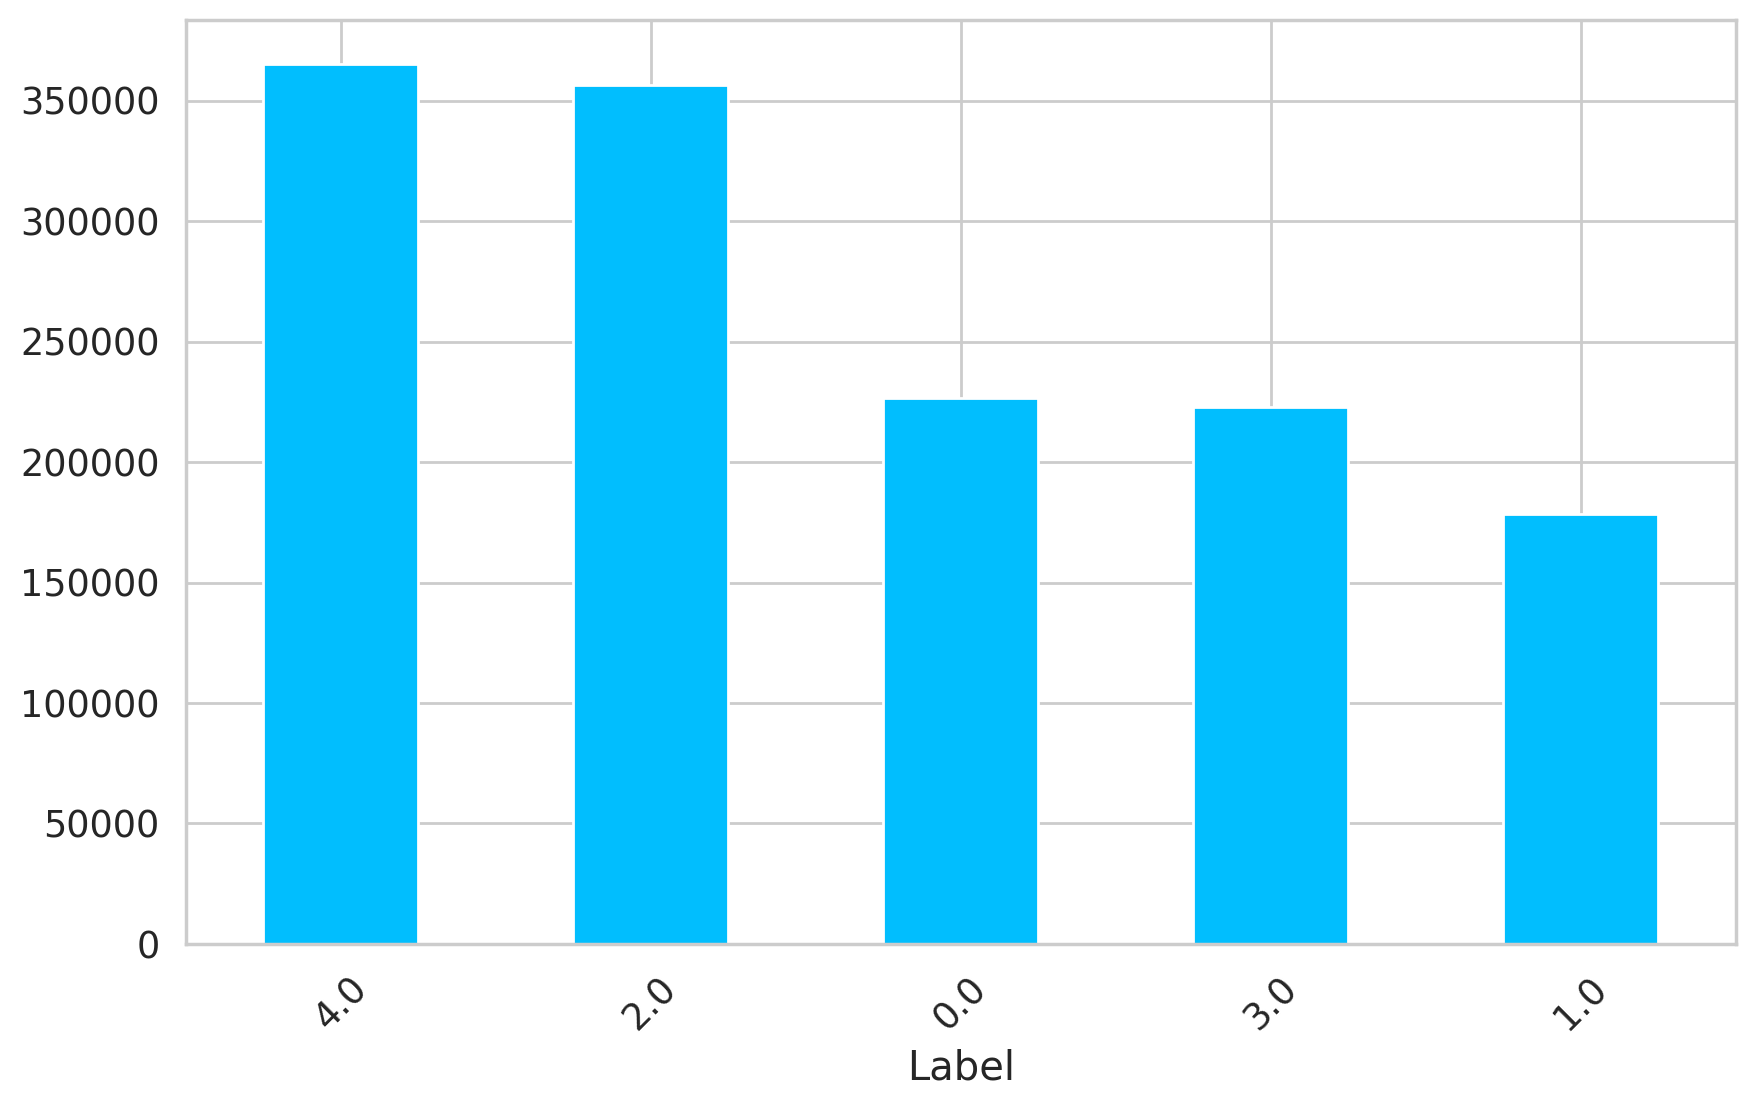

In [25]:
y.Label.value_counts().plot(kind='bar');
plt.xticks(rotation=45)
plt.show()

### Preprocessing

C начала просто закодируем переменные и затем добавим их обратно в датафрейм

In [26]:
FEATURE_COLUMNS = list(X_concreat.columns)
FEATURE_COLUMNS

['F1', 'F2', 'F3', 'F4']

In [27]:
train_sequences, test_valid_sequences = train_test_split(sequences, test_size=0.3)
valid_sequences, test_sequences = train_test_split(test_valid_sequences, test_size=0.7)
len(train_sequences), len(valid_sequences), len(test_sequences)

(944988, 121498, 283497)

### Dataset

In [28]:
class SurfaceDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(sequence = torch.Tensor(sequence.to_numpy()), label = torch.tensor(label).long())
    

In [29]:
class SurfaceDataModule(pl.LightningDataModule):
    
    def __init__(self, train_sequences, valid_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.valid_sequences = valid_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.val_dataset = SurfaceDataset(self.valid_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle=True,
            num_workers = cpu_count())
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size = self.batch_size,
            shuffle=False,
            num_workers = cpu_count())
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle=False,
            num_workers = cpu_count())

In [30]:
N_EPOCHS = 1
BATCH_SIZE = 16

data_module = SurfaceDataModule(train_sequences, valid_sequences, test_sequences, BATCH_SIZE)

### Model

In [65]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_features, n_classes, n_hidden=9, n_layers=1):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=n_features,
            num_layers=n_layers,
            hidden_size=n_hidden,
            batch_first=True,
            dropout=0.75,
            bidirectional=True)
    
        self.classifier1 = nn.Linear(2*n_hidden, n_classes)

        
    def forward(self, x):
        self.gru.flatten_parameters()
        _, hidden = self.gru(x)
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        return self.classifier1(out)

In [66]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.n_classes = n_classes
        self.predictions = []
        self.labels = []
        self.predictions_raw = []


    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(task='multiclass', num_classes=self.n_classes, preds=predictions, target=labels)

        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(task='multiclass', num_classes=self.n_classes, preds=predictions, target=labels)

        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        predictions_raw = outputs.softmax(1)[[list(range(len(batch['label'])))], labels].squeeze()
        self.predictions += predictions.tolist()
        self.labels += labels.tolist()
        self.predictions_raw += predictions_raw.tolist()
        step_accuracy = accuracy(task='multiclass', num_classes=self.n_classes, preds=predictions, target=labels)

        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_accuracy', step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = 0.0001)

In [67]:
model = SurfacePredictor(n_features=len(FEATURE_COLUMNS), n_classes=5)
checkpoint_callback = ModelCheckpoint(dirpath = 'checkpoints',
                                      filename='checkpoint',
                                      save_top_k=1,
                                      verbose=True,
                                      monitor='val_loss',
                                      mode='min')
logger = TensorBoardLogger("lightning_logs_unitree", name="gru_standart_PCA_20h_1_5_adamw_final") #l;,l,mpo

In [68]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [69]:
trainer = pl.Trainer(logger=logger, max_epochs=N_EPOCHS, log_every_n_steps=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [75]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 905   
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
905       Trainable params
0         Non-trainable params
905       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7f491f928c20>
Traceback (most recent call last):
  File "/home/aliud/anaconda3/envs/LSTM/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


Training: 0it [00:00, ?it/s]

In [152]:
# path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path
# trainer = pl.Trainer(logger=logger, max_epochs=1)
# trainer.fit(model, data_module, ckpt_path=path_to_best_checkpoint)

### Predictions

In [70]:
trained_model = SurfacePredictor.load_from_checkpoint('/home/aliud/Documents/LSTM/lightning_logs_unitree/gru_standart_PCA_9h_1_4_adamw_1hidden/version_0/checkpoints/epoch=0-step=59062.ckpt', #jnbkjnjlknlkjnj
                                                      n_features=len(FEATURE_COLUMNS),
                                                      n_classes=5
                                                      )

trained_model.freeze()

In [71]:
trainer.test(trained_model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9969805479049683     │
│         test_loss         │   0.015123004093766212    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.015123004093766212, 'test_accuracy': 0.9969805479049683}]

In [72]:
classes_list = ['Concrete', 'Ice', 'Titles', 'Wet', 'Wood']

In [73]:
print(classification_report(trained_model.labels, trained_model.predictions, target_names=classes_list, digits=5))

              precision    recall  f1-score   support

    Concrete    0.99751   0.99845   0.99798     47736
         Ice    0.99199   0.99308   0.99254     37293
      Titles    0.99664   0.99655   0.99660     47012
         Wet    0.99686   0.99581   0.99634     74714
        Wood    0.99940   0.99936   0.99938     76742

    accuracy                        0.99698    283497
   macro avg    0.99648   0.99665   0.99657    283497
weighted avg    0.99698   0.99698   0.99698    283497



In [182]:
print(classification_report(trained_model.labels, trained_model.predictions, target_names=classes_list, digits=5))

              precision    recall  f1-score   support

    Concrete    0.99956   0.99998   0.99977     47546
         Ice    0.99661   0.99825   0.99743     37095
      Titles    0.99964   0.99994   0.99979     47193
         Wet    0.99933   0.99872   0.99903     74903
        Wood    1.00000   0.99936   0.99968     76760

    accuracy                        0.99925    283497
   macro avg    0.99903   0.99925   0.99914    283497
weighted avg    0.99925   0.99925   0.99925    283497



In [183]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True surface')
    plt.xlabel('Predicted surface')

In [74]:
cm = confusion_matrix(trained_model.labels, trained_model.predictions)
pd.DataFrame(cm, index=classes_list, columns=classes_list)

,Concrete,Ice,Titles,Wet,Wood
Concrete,47662,4,14,56,0
Ice,7,37035,126,125,0
Titles,11,121,46850,5,25
Wet,100,174,18,74401,21
Wood,1,0,0,48,76693


In [58]:
cm = confusion_matrix(trained_model.labels, trained_model.predictions)
pd.DataFrame(cm, index=classes_list, columns=classes_list)

,Concrete,Ice,Titles,Wet,Wood
Concrete,47734,0,1,1,0
Ice,34,36807,67,385,0
Titles,65,4,46943,0,0
Wet,121,199,6,74380,8
Wood,1,0,0,60,76681
